
# Part 1: Caption Generation

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive


In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [4]:
root_captioning = "/content/drive/My Drive/CS269_NLG/"

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [7]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [8]:
len(img)

8091

In [9]:
train_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [10]:
train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [11]:
print(len(train_images))
print(len(test_images))

6000
1000


In [12]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [13]:
len(train_descriptions)

6000

In [14]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


In [15]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [17]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [18]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [19]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [20]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [21]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [22]:
max_length +=2
print(max_length)

34


In [23]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [24]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400001it [00:19, 20952.22it/s]

Found 400001 word vectors.


In [25]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(1652, 200)

In [27]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [28]:
embedding_dim

200

In [29]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [30]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [32]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

In [33]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/My Drive/CS269_NLG/Flicker8k_Dataset/401079494_562454c4d6.jpg


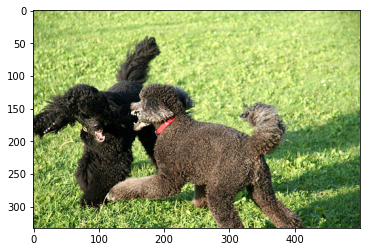

Caption: black dog is running through the grass
_____________________________________
/content/drive/My Drive/CS269_NLG/Flicker8k_Dataset/3727752439_907795603b.jpg


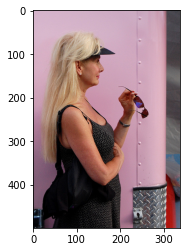

Caption: man in black shirt and hat is standing in front of doorway
_____________________________________
/content/drive/My Drive/CS269_NLG/Flicker8k_Dataset/405615014_03be7ef618.jpg


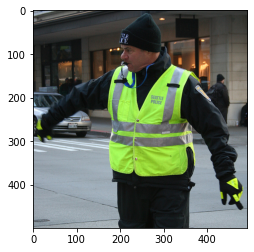

Caption: man in red shirt and woman in red shirt are standing in front of red building
_____________________________________
/content/drive/My Drive/CS269_NLG/Flicker8k_Dataset/387830531_e89c192b92.jpg


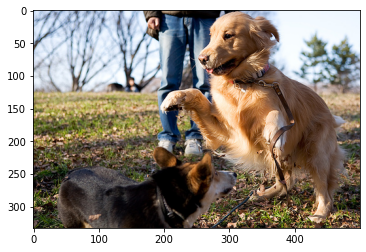

Caption: two dogs are running through the grass
_____________________________________


In [34]:
for z in range(4): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [35]:
encoding_test[pic].shape

(2048,)

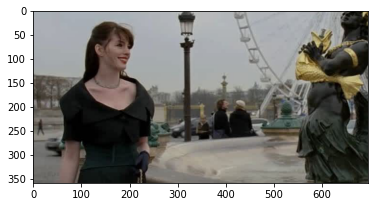

(1, 2048)
Caption: woman in white shirt and heels is walking past large houses
_____________________________________


In [38]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

ROOT = "https://github.com/Aishwarya3011/Photos/blob/main/" 

urls = [
  ROOT+"Image_2.jpeg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

#Part 2: Text processing

In [37]:
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 11.7 MB/s 
     |████████████████████████████████| 4.2 MB 91.0 MB/s 
     |████████████████████████████████| 346 kB 85.0 MB/s 
     |████████████████████████████████| 212 kB 78.5 MB/s 
     |████████████████████████████████| 1.1 MB 64.3 MB/s 
     |████████████████████████████████| 86 kB 6.6 MB/s 
     |████████████████████████████████| 140 kB 98.1 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 90.3 MB/s 
     |████████████████████████████████| 127 kB 85.6 MB/s 
     |████████████████████████████████| 6.6 MB 81.3 MB/s 
     |████████████████████████████████| 144 kB 79.3 MB/s 
     |████████████████████████████████| 271 kB 78.6 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████|

In [38]:
from happytransformer import HappyGeneration

In [39]:
happy_gen = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-125M")

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

06/01/2022 17:24:46 - INFO - happytransformer.happy_transformer -   Using model: cuda


## Dataset 1: Twitter Sarcasm

In [40]:
import csv
import urllib.request

def filtered(sentence):
  words = sentence.split()
  filter = ['sarcasm', 'sarcastic', 'reposting', '<url>', 'joke', 'humour', 'humor', 'jokes', 'irony', 'ironic', 'exgag']
  for filtered_word in filter:
    if filtered_word in words:
      return True
  return False


def download_and_clean(url, output_file, text_index, labels_index, to_filter=False):
  with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['text', 'labels'])
    file = urllib.request.urlopen(url)
    for line in file:
      decoded_line = line.decode('utf-8')
      row = eval(decoded_line)
      if not to_filter or not filtered(row[text_index]):
        csv_writer.writerow([row[text_index], row[labels_index]])

In [41]:
download_and_clean('https://raw.githubusercontent.com/headacheboy/data-of-multimodal-sarcasm-detection/master/text/train.txt', 'train.csv', 1, 2, to_filter=True)
download_and_clean('https://raw.githubusercontent.com/headacheboy/data-of-multimodal-sarcasm-detection/master/text/test2.txt', 'test.csv', 1, 3)
download_and_clean('https://raw.githubusercontent.com/headacheboy/data-of-multimodal-sarcasm-detection/master/text/valid2.txt', 'validate.csv', 1, 3)

In [42]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
validate_df = pd.read_csv('validate.csv')
train_df.head()

,text,labels
0,<user> thanks for showing up for our appointme...,1
1,haha . # lol,1
2,i love waiting <num> min for a cab - such shor...,1
3,22 super funny quotes # funnyquotes # funnysa...,1
4,goog morning # sorrynotsorry # morning,1


In [43]:
data = [[train_df.labels.value_counts()[0], test_df.labels.value_counts()[0], validate_df.labels.value_counts()[0]], 
        [train_df.labels.value_counts()[1], test_df.labels.value_counts()[1], validate_df.labels.value_counts()[1]]]
# Prints out the dataset sizes of train test and validate as per the table.
pd.DataFrame(data, columns=["Train", "Test", "Validate"])

,Train,Test,Validate
0,11174,1450,1451
1,8642,959,959


In [44]:
train_df["text"]

0        <user> thanks for showing up for our appointme...
1                                            haha .  # lol
2        i love waiting <num> min for a cab - such shor...
3        22 super funny quotes # funnyquotes  # funnysa...
4                  goog morning  # sorrynotsorry # morning
                               ...                        
19811    retweet if you love this cutie pie # mendesarm...
19812                such a good read emoji_7810 emoji_238
19813    this is some people 's living conditions , alw...
19814    winner - seungyoon ( simple ) - rt if u save -...
19815    ok but concept : kravitz passing notes between...
Name: text, Length: 19816, dtype: object

In [45]:
train_path = "train.txt"

In [46]:
eval_path = "eval.txt"

In [47]:
def generate_text(path, dataset):
  with open(path, "w") as text_file:
    text = dataset["text"]
    for case in text:      
      summary = case
      text_file.write(summary + "\n")

In [48]:
generate_text(train_path, train_df)

In [49]:
generate_text(eval_path, test_df)

In [50]:
result_before = happy_gen.eval(eval_path)

06/01/2022 17:24:58 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-98d684174cd276e2/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

06/01/2022 17:24:59 - INFO - happytransformer.happy_transformer -   Evaluating...
***** Running Evaluation *****
  Num examples = 25
  Batch size = 1


In [51]:
print("Before:", result_before.loss)

Before: 5.115182399749756


### Model Training

In [52]:
from happytransformer import GENTrainArgs

In [53]:
train_args = GENTrainArgs(num_train_epochs=3, learning_rate=5e-5)

In [54]:
happy_gen.train(train_path, args=train_args)

06/01/2022 17:25:03 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-96ad161e19559afa/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

06/01/2022 17:25:06 - INFO - happytransformer.happy_transformer -   Training...
PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 199
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 597


Step,Training Loss
500,4.297600




Training completed. Do not forget to share your model on huggingface.co/models =)




In [55]:
result_after= happy_gen.eval(eval_path)

06/01/2022 17:29:37 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

06/01/2022 17:29:38 - INFO - happytransformer.happy_transformer -   Evaluating...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 25
  Batch size = 1


In [56]:
print(result_after.loss)

4.32495641708374


In [57]:
prompt = "A boy is playing in the school"

In [58]:
result_ft = happy_gen.generate_text(prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [59]:
print("Result FT: ", result_ft.text)

Result FT:   of the future. # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture # thefuture #


## Performance tuning with different generation algorithms



1.   Greedy algorithm
2.   Generic Sampling
3.   k-means sampling



In [60]:
from happytransformer import GENSettings

In [61]:
greedy_settings = GENSettings(no_repeat_ngram_size=2,  max_length=50)

In [62]:
generic_sampling_settings = GENSettings(do_sample=True, top_k=0, temperature=0.5,  max_length=50)

In [63]:
top_k_sampling_settings = GENSettings(do_sample=True, top_k=15, temperature=0.5,  max_length=50, no_repeat_ngram_size=2)

In [64]:
result_ft = happy_gen.generate_text(prompt, args=generic_sampling_settings)
print("Result FT: ", result_ft.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result FT:   for the first time in more than a century. # funny # funnytheday # funnymydad emoji_623 emoji_623 emoji_623 emoji_623 emoji_623 emoji_623 emoji_623 emoji_623 emoji_623 emoji_


In [65]:
result_ft = happy_gen.generate_text(prompt, args=greedy_settings)
print("Result FT: ", result_ft.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result FT:   of the future. # thefuture # nyc # womensmarch # wmw # mondaymonday # wednesdaymood # funny # comedy # memes # meme # lol # lolsarcasm # fun # hilarious #


In [66]:
result_ft = happy_gen.generate_text(prompt, args=top_k_sampling_settings)
print("Result FT: ", result_ft.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result FT:   parking lot in his neighborhood today and he has a lot of things to say about it. # mondaymemes # truestory # funny # meme # memes # lol # lolsarcasm # fun # laugh # funnysayings #


## Dataset 2: Sarcasm_v2

In [67]:
import csv

In [68]:
collected_sarcasm_Data = []

In [69]:
file = open(root_captioning + 
            'sarcasm_v2/GEN-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [70]:
file = open(root_captioning + 
            'sarcasm_v2/HYP-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [71]:
file = open(root_captioning + 
            'sarcasm_v2/RQ-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [72]:
print(collected_sarcasm_Data)

['To the exclusion of all others? I thought you were working for acceptance and inclusion. You are the only one allowed to "exclude?" \n', 'Short, yet pointless.\nThis is the third post in a row where you have utterly and completely failed to address any of the content of what you have quoted from me.\nLets see if we can make it FOUR!', "Anyone who can read the entire page will find that Zeus is in there, but since you apparently can't read I forgive your ignorance.. emoticonXByeemoticonXBye", "It's only obvious to the delusional ones, as I did not lift it from anyone. Just stating the truth. If it hurts, tough.", 'So you disagree with Zardoz then? True christians are those who profess faith and bear false witness? True christians are those who are ignorant, vain, boastful insulting liars?\nInteresting...', 'Aaahhh, so just not accomplishing our goals and going home is not defeat, there has to be paperwork for it to be a defeat. Gotcha. \n', "You'd have to drown a few puppies too. Kitt

In [73]:
print(len(collected_sarcasm_Data))

4693


In [74]:
from sklearn.model_selection import train_test_split

In [75]:
train, test = train_test_split(collected_sarcasm_Data, test_size = 0.2)

In [76]:
print(len(train))
print(len(test))

3754
939


In [77]:
train_v2_path = "train_v2.txt"

In [78]:
eval_v2_path = "eval_v2.txt"

In [79]:
def generate_text_v2(path, dataset):
  with open(path, "w") as text_file:
    for data in dataset:     
      text_file.write(data + "\n")

In [80]:
generate_text_v2(train_v2_path, train)

In [81]:
generate_text_v2(eval_v2_path, test)

In [82]:
result_before = happy_gen.eval(eval_v2_path)

06/01/2022 17:29:45 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-c27d57a2ec35dc72/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

06/01/2022 17:29:46 - INFO - happytransformer.happy_transformer -   Evaluating...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 24
  Batch size = 1


In [83]:
print("Before:", result_before.loss)

Before: 4.803192138671875


### Model training on Sarcasm_v2

In [84]:
train_args = GENTrainArgs(num_train_epochs=3, learning_rate=5e-5)

In [85]:
happy_gen.train(train_v2_path, args=train_args)

06/01/2022 17:29:49 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-9a248cd9f3663064/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

06/01/2022 17:29:51 - INFO - happytransformer.happy_transformer -   Training...
PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 95
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 285


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [86]:
result_after= happy_gen.eval(eval_path)
result_after.loss

06/01/2022 17:32:01 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

06/01/2022 17:32:01 - INFO - happytransformer.happy_transformer -   Evaluating...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 25
  Batch size = 1


4.721092700958252

In [87]:
prompt2 = 'Man and woman are going to the zoo'

In [88]:
prompt3 = 'A guy is riding a bicycle'

In [89]:
prompt4 = 'Man and dog are playing with ball in the sand'

In [90]:
result_ft = happy_gen.generate_text(prompt2)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [91]:
print("Result FT: ", result_ft.text)

Result FT:   to watch the zoo animals.                                            


In [92]:
result_ft = happy_gen.generate_text(prompt3)
print("Result FT: ", result_ft.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result FT:   on a cliff face.                                             


In [93]:
result_ft = happy_gen.generate_text(prompt4)
print("Result FT: ", result_ft.text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result FT:  .                                                 


# Code playground 1

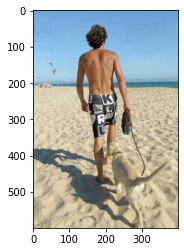

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


(1, 2048)
Caption: man and dog are playing with ball in the sand
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm .                                                 
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Greedy: .   I think the only way to get a gun is to have it in your pocket. I'm not sure how you can get one in a pocket, but you could get it out of a bag and put it on your head. You
_____________________________________


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Generic: , you know that?                                             
_____________________________________
Generated Sarcasm Top k: .   I don't know what the hell you are talking about. It's a question of what I'm talking to you. I am not a lawyer. You are not even a politician. Just because you have no idea what you're talking
_____________________________________


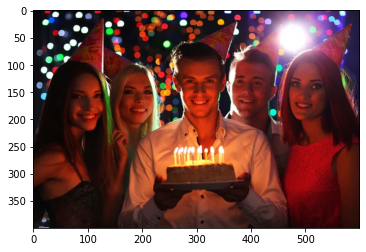

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


(1, 2048)
Caption: woman in red dress is standing in front of microphone that is advertising
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm  the new "Rolleye" (Rolleye) in the new "Rolleye" (Rolleye) in the new "Rolleye" (Rolleye) in the new "Rol
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Greedy:  the new "Rolleye" (ROL) in the country.   I think that the "new" is a good idea. I'm not sure what the word "roast" means. It's a very popular term.
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Generic:  a new car. i'm not surprised that you have to be. lol. the british government is a bunch of hypocrites.  they are all hypocrites.  what's the difference?  i'm not a liberal, but i
_____________________________________
Generated Sarcasm Top k:  the new "Budget" bill.   You can see that the budget is a mess. You have to be a conservative to vote for it. It doesn't help that you have a great deal of money to spend on it, so you
_____________________________________


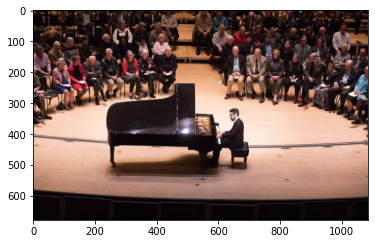

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


(1, 2048)
Caption: group of people are standing around and reading
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm  the Bible.                                               
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Greedy:  the Bible.   I think that's a good thing. I'm not sure what the hell you're talking about. You're not a christian, you are a Christian. And you don't have to be a virgin to have a Bible
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Generic:  the same thing, and they're right. But, you know, I don't see how that's a problem. It's not a problem at all. And, you know, I don't see how that's a problem at all. Oh
_____________________________________
Generated Sarcasm Top k:  the news.   You're a genius. You know what you're talking about. I'm not sure that you can understand the word "fool" or you don't even know it. Maybe you should just go and read the papers and
_____________________________________


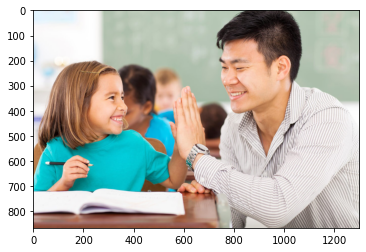

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


(1, 2048)
Caption: two young girls are posing for photograph
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm  in the'real world' of the'real world' of the'real world' of the'real world' of the'real world' of the'real world' of the'real world' of the'real world' of the
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Greedy:  in the'real world' of the world.   The 'ex-patriot' is a woman who has been in a relationship for a long time. She is the one who is in love with you. You are the only one that
_____________________________________


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Sarcasm Generic:  with the boys of the country. This is the first time I have seen this and I'm not surprised.Who would you expect me to be if I didn't know you? I am surprised you didn't know me.You are not a child
_____________________________________
Generated Sarcasm Top k:  in front of the sign of a woman who is being held in a holding cell in the US. It says, 'You are a criminal, and you have committed a crime.''I'm not sure if you know, but I don't know
_____________________________________


In [94]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

ROOT = "https://github.com/Aishwarya3011/Photos/blob/main/" 

urls = [
  ROOT+"Man_Dog.jpeg?raw=true",
  ROOT+"Pic2.jpeg?raw=true",
  ROOT+"Pic3.jpeg?raw=true",
  ROOT+"Pic4.jpeg?raw=true"
]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  generatedCaption = generateCaption(img)
  print(img.shape)
  print("Caption:", generatedCaption)
  print("_____________________________________")
  print("Generated Sarcasm", happy_gen.generate_text(generatedCaption).text)
  print("_____________________________________")
  print("Generated Sarcasm Greedy:", happy_gen.generate_text(generatedCaption, greedy_settings).text)
  print("_____________________________________")
  print("Generated Sarcasm Generic:", happy_gen.generate_text(generatedCaption, generic_sampling_settings).text)
  print("_____________________________________")
  print("Generated Sarcasm Top k:", happy_gen.generate_text(generatedCaption, top_k_sampling_settings).text)
  print("_____________________________________")



# Part 3: Refining the predictions

1.   POS Extraction
2.   Causality
3.   Data Augmentation



In [95]:
import spacy
import requests, json
from transformers import pipeline

In [96]:
sp = spacy.load('en_core_web_sm')

In [97]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2kemjnlg


Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
creating metadata file for /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
loading configuration file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dr

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
creating metadata file for /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
loading weights file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-engl

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/9f284be68d0cfa5298eea908fc7f51cc7e0b01c7aaf2eba99c70d938b169bfe8.ba4a40df74471cdc82cd580af48bbbcfd25e9095a9d4bb296f711f3af7e2619e
creating metadata file for /root/.cache/huggingface/transformers/9f284be68d0cfa5298eea908fc7f51cc7e0b01c7aaf2eba99c70d938b169bfe8.ba4a40df74471cdc82cd580af48bbbcfd25e9095a9d4bb296f711f3af7e2619e
loading configuration file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "cla

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
creating metadata file for /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpr98nijcu


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
creating metadata file for /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpp9obqqac


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/e7bd01a8669e2d76258ba5ab711ba48da69b2dfc573c7b02566c0e73bd4583f4.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/e7bd01a8669e2d76258ba5ab711ba48da69b2dfc573c7b02566c0e73bd4583f4.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4

In [98]:
print(len(collected_sarcasm_Data))

4693


In [99]:
def write_to_csv():

  # open the file in the write mode
  with open(root_captioning + 
              'sarcasm_v2/SarcasmV2.csv', 'w', encoding='UTF8') as f:

      writer = csv.writer(f)

      for row in collected_sarcasm_Data:
        writer.writerow([row])

In [100]:
write_to_csv()

In [101]:
def clear_csv():
  f = open(root_captioning + 
              'sarcasm_v2/SarcasmV2.csv', 'w', encoding='UTF8')
  f.truncate()
  f.close()

In [102]:
def verb_scraper(verb):
  verb += ''

  results = []
  sentiments = []

  headers = {
    "User-Agent":
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.19582"
  }

  response = requests.get('http://google.com/complete/search?client=chrome&q=' + verb + 'causes' , headers=headers)
  for result in json.loads(response.text)[1]:
      results.append(result)

  for result in results:
    sen = sentiment_analysis(result)
    if sen[0]['label'] == 'NEGATIVE':
      if len(sentiments) == 0 or sentiments[0] == sen[0]['score']:
        sentiments.append(sen[0]['score'])
        sentiments.append(result)
      elif sentiments[0] < sen[0]['score']:
        sentiments = []
        sentiments.append(sen[0]['score'])
        sentiments.append(result)

  new_data = []

  for i in range(len(sentiments) - 1):
    #  collected_sarcasm_Data.append(sentiments[i+1])
     new_data.append(sentiments[i+1])
     print(sentiments[i+1])
     i += 2
    #  clear_csv()
    #  write_to_csv()

  return collected_sarcasm_Data[len(collected_sarcasm_Data) - 1]

In [105]:
def cause_generator(prompt):
  sen = sp(prompt)

  # Causality inference
  verbs = []

  for i in range(len(sen)):
    if sen[i].pos_ == "VERB":
      verbs.append(sen[i].text)

  for verb in verbs:
    return verb_scraper(verb)


In [106]:
cause_generator('A man and his dog are walking')

walking causes back pain


'walking causes back pain'

In [109]:
sarcastic_add_ons = [
    "Good god!",
    "What fun!",
    "I love it!",
    "I love when this happens!",
    "Just what I needed",
    "Can it get any better?",
    "God loves me truly!",
    "How great is that!"
]

In [112]:
import random

In [114]:
random.shuffle(sarcastic_add_ons)
output = cause_generator('A man and his dog are walking') + '.' + sarcastic_add_ons[0] + "!"
output

walking causes back pain


'walking causes back pain.How great is that!!'

In [115]:
random.shuffle(sarcastic_add_ons)
output = cause_generator('Two girls are singing') + '.' + sarcastic_add_ons[0] + "!"
output

singing causes yawning


'singing causes yawning.I love when this happens!'